Midterm Report (Code)

Fuentes, Paolo <br>
Pecundo, Allan <br>
Villegas, Mylene <br> <br>

CSCI 271-A

In [ ]:
#Importing the standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### I. Data Preprocessing

#### Reading the Data

In [ ]:
df_movies = pd.read_csv('/content/drive/MyDrive/CSCI 271 - Group 6/Dataset/tmdb_5000_movies.csv')
df_credits = pd.read_csv('/content/drive/MyDrive/CSCI 271 - Group 6/Dataset/tmdb_movie_genres.csv')


#### Unpacking Genres Feature - For Documentation, No Need to Re-run

In [ ]:
#### For Documentation, do not run again ####

#Genres were unpacked and saved as a separate csv file

genres_df = pd.DataFrame(df_movies[['id','genres']])

#Create a function to only extract 'name' and exclude 'id' from the json column
def process_jsoncols(colname):
    jsoncollist=[]
    for x in colname:
        jsoncollist.append(x['name'])
    return jsoncollist

#Preprocess the json column
genres_df['genres'] = genres_df['genres'].apply(json.loads, encoding="utf-8")
genres_df['genres'] = genres_df['genres'].apply(process_jsoncols) 
genres_df['genres'] = genres_df['genres'].apply(lambda x: ','.join(map(str, x)))

#For one hot encoding:

#Create list
genres_list = set()
for sstr in genres_df['genres'].str.split(','):
    genres_list = set().union(sstr, genres_list)
genres_list = list(genres_list)
genres_list.remove('')

for genres in genres_list:
    genres_df[genres] = genres_df['genres'].str.contains(genres).apply(lambda x:1 if x else 0)

#Rename columns

cols = genres_df.columns[~genres_df.columns.isin(['id','genres'])]

genres_df.rename(columns = dict(zip(cols, 'genre_' + cols)), inplace=True)

genres_df.drop(['genres'], axis=1, inplace=True)


#genres_df.to_csv("tmdb_movie_genres.csv") - Genres was saved as separate csv for easier loading in experimentation





In [ ]:
#Shortening the genres
genres_df = genres_df.loc[:,['id',
                       'genre_Action', 
                        'genre_Adventure',  
                        'genre_Comedy', 
                        'genre_Crime', 
                        'genre_Drama', 
                        'genre_Family', 
                        'genre_Horror', 
                        'genre_Romance', 
                        'genre_Science Fiction',
                        'genre_Thriller']]

genres_df['genre_Others'] = genres_df.drop(['id'], axis = 1).sum(axis = 1)

genres_df['genre_Others'] = [1 if x > 0 else 0 for x in genres_df['genre_Others']]


#genres_df.to_csv("tmdb_movie_genres_shortened.csv") - Genres was saved as separate csv for easier loading in experimentation



In [ ]:
genres_df

,id,genre_Action,genre_Adventure,genre_Comedy,genre_Crime,genre_Drama,genre_Family,genre_Horror,genre_Romance,genre_Science Fiction,genre_Thriller,genre_Others
0,19995,1,1,0,0,0,0,0,0,1,0,1
1,285,1,1,0,0,0,0,0,0,0,0,1
2,206647,1,1,0,1,0,0,0,0,0,0,1
3,49026,1,0,0,1,1,0,0,0,0,1,1
4,49529,1,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4798,9367,1,0,0,1,0,0,0,0,0,1,1
4799,72766,0,0,1,0,0,0,0,1,0,0,1
4800,231617,0,0,1,0,1,0,0,1,0,0,1
4801,126186,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_movies.describe() #Checking summary statistics for atypical data

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


There are observations with 0 budget and 0 revenue. Remove these.

#### Removing rows with 0 budget and 0 revenue

In [ ]:
df_movies = df_movies.loc[(df_movies['budget'] != 0) & (df_movies['revenue'] != 0)]

#### Removing rows with status being not released

In [ ]:
df_movies['status'].value_counts() #Inspecting movie status of release

Released           3228
Post Production       1
Name: status, dtype: int64

In [ ]:
df_movies = df_movies.loc[(df_movies['status'] == 'Released')] #Keeping only rows (or movies) that are released

df_movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


#### Getting Year of Release Feature

In [ ]:
df_movies['year'] = df_movies['release_date'].astype(str).str[0:4].astype(int) #Year column is created by taking the first 4 characters of the released_date feature and transforming it into integer

df_movies.describe() #Confirming if Year columns was created correctly as feature

,budget,id,popularity,revenue,runtime,vote_average,vote_count,year
count,3.228000e+03,3228.000000,3228.000000,3.228000e+03,3228.000000,3228.000000,3228.000000,3228.000000
mean,4.066642e+07,44778.817844,29.042156,1.212803e+08,110.724907,6.309665,977.585812,2001.677509
std,4.439840e+07,74620.916870,36.168131,1.863197e+08,20.968920,0.873846,1414.427021,13.280569
min,1.000000e+00,5.000000,0.019984,5.000000e+00,41.000000,0.000000,0.000000,1916.000000
25%,1.050000e+07,4956.250000,10.468206,1.700000e+07,96.000000,5.800000,178.000000,1998.000000
50%,2.500000e+07,11446.500000,20.412963,5.519150e+07,107.000000,6.300000,471.000000,2005.000000
75%,5.500000e+07,45269.750000,37.340747,1.463434e+08,121.000000,6.900000,1148.000000,2010.000000
max,3.800000e+08,417859.000000,875.581305,2.787965e+09,338.000000,8.500000,13752.000000,2016.000000


In [ ]:
df_movies.info() #Checking for missing data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3228 entries, 0 to 4798
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                3228 non-null   int64  
 1   genres                3228 non-null   object 
 2   homepage              1346 non-null   object 
 3   id                    3228 non-null   int64  
 4   keywords              3228 non-null   object 
 5   original_language     3228 non-null   object 
 6   original_title        3228 non-null   object 
 7   overview              3228 non-null   object 
 8   popularity            3228 non-null   float64
 9   production_companies  3228 non-null   object 
 10  production_countries  3228 non-null   object 
 11  release_date          3228 non-null   object 
 12  revenue               3228 non-null   int64  
 13  runtime               3228 non-null   float64
 14  spoken_languages      3228 non-null   object 
 15  status               

#### Feature Preperation

In [ ]:
success_cutoff = 1 #Cut-off in percentage (expressed as decimal) of ROI to consider a movie successful

df_movies['profit_pct'] = (df_movies['revenue'] - df_movies['budget'])/(df_movies['budget']) #Calculation of ROI

df_movies['success'] = [1 if x > success_cutoff else 0 for x in df_movies['profit_pct'] ] #Successful movies are defined as group of movies that fall above the cut-off in terms of ROI. They are reflected as positive class or "1"

### II. Building Model - with genres

In [ ]:
#Preprocessing pipeline


#Reading values and cleaning
df_movies = pd.read_csv('/content/drive/MyDrive/CSCI 271 - Group 6/Dataset/tmdb_5000_movies.csv')
df_genres = pd.read_csv('/content/drive/MyDrive/CSCI 271 - Group 6/Dataset/tmdb_movie_genres_shortened.csv')

df_movies = df_movies.loc[(df_movies['budget'] != 0) & (df_movies['revenue'] != 0)]
df_movies = df_movies.loc[(df_movies['status'] == 'Released')]
df_movies['year'] = df_movies['release_date'].astype(str).str[0:4].astype(int)

#Creating target variable

success_cutoff = 1 

df_movies['profit_pct'] = (df_movies['revenue'] - df_movies['budget'])/(df_movies['budget'])

df_movies['success'] = [1 if x > success_cutoff else 0 for x in df_movies['profit_pct']]

In [ ]:
#Preparing pre-processed Genres dataframe for merging with original movie dataframe

df_genres.drop('Unnamed: 0', axis = 1,inplace = True)
df_genres.set_index('movie_id', inplace = True)

In [ ]:
df_movies.describe() #Checking new dataframe

,budget,id,popularity,revenue,runtime,vote_average,vote_count,year,profit_pct,success
count,3.228000e+03,3228.000000,3228.000000,3.228000e+03,3228.000000,3228.000000,3228.000000,3228.000000,3.228000e+03,3228.00000
mean,4.066642e+07,44778.817844,29.042156,1.212803e+08,110.724907,6.309665,977.585812,2001.677509,2.954738e+03,0.55886
std,4.439840e+07,74620.916870,36.168131,1.863197e+08,20.968920,0.873846,1414.427021,13.280569,1.506334e+05,0.49660
min,1.000000e+00,5.000000,0.019984,5.000000e+00,41.000000,0.000000,0.000000,1916.000000,-9.999995e-01,0.00000
25%,1.050000e+07,4956.250000,10.468206,1.700000e+07,96.000000,5.800000,178.000000,1998.000000,2.482082e-02,0.00000
50%,2.500000e+07,11446.500000,20.412963,5.519150e+07,107.000000,6.300000,471.000000,2005.000000,1.300444e+00,1.00000
75%,5.500000e+07,45269.750000,37.340747,1.463434e+08,121.000000,6.900000,1148.000000,2010.000000,3.420879e+00,1.00000
max,3.800000e+08,417859.000000,875.581305,2.787965e+09,338.000000,8.500000,13752.000000,2016.000000,8.499999e+06,1.00000


In [ ]:
feats = ['budget','year','runtime','id','success'] #Selecting features from original dataframe to be used and merged with genres

df_movies = df_movies[feats].set_index('id') #Setting index of movies dataframe for merging

#df_genres.drop('Unnamed: 0', axis = 1, inplace = True)
df_movies_new = pd.merge(left = df_movies, right = df_genres, left_index = True, right_index = True) #Merging new dataframe

In [ ]:
#Checking new dataframe

df_movies_new

,budget,year,runtime,success,genre_Action,genre_Adventure,genre_Comedy,genre_Crime,genre_Drama,genre_Family,genre_Horror,genre_Romance,genre_Science Fiction,genre_Thriller,genre_others
19995,237000000,2009,162.0,1,1,1,0,0,0,0,0,0,1,0,0
285,300000000,2007,169.0,1,1,1,0,0,0,0,0,0,0,0,0
206647,245000000,2015,148.0,1,1,1,0,1,0,0,0,0,0,0,0
49026,250000000,2012,165.0,1,1,0,0,1,1,0,0,0,0,1,0
49529,260000000,2012,132.0,0,1,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2292,27000,1994,92.0,1,0,0,1,0,0,0,0,0,0,0,0
692,12000,1972,93.0,1,0,0,1,1,0,0,1,0,0,0,0
36095,20000,1997,111.0,1,0,0,0,1,0,0,1,0,0,1,0
14337,7000,2004,77.0,1,0,0,0,0,1,0,0,0,1,1,0


In [ ]:
#Prepping input features and output features for model training

X = df_movies_new.drop('success',axis = 1)
y = df_movies_new['success'].astype('str')

In [ ]:
#Splitting model into train and test set

random_state = 42
test_size = 0.2

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Class Distribution of Training Set')

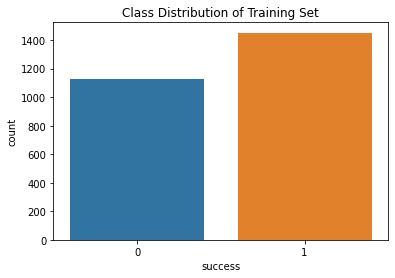

In [ ]:
 #Checking the class balance in training set
sns.countplot(y_train)
plt.title('Class Distribution of Training Set')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Class Distribution of Test Set')

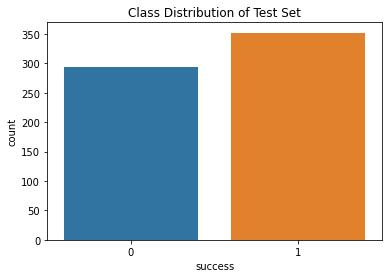

In [ ]:
 #Checking the class balance in test set
sns.countplot(y_test)
plt.title('Class Distribution of Test Set')

Classes look balanced with slight skew in count towards movies that are successful (positive class)

In [ ]:
#Importing packages for model building

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


In [ ]:
#Importing packages for metrics

from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve, precision_recall_fscore_support


#### Logistic Regression

In [ ]:
#Building and fitting model
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#Checking classificatoin metrics
print(classification_report(y_pred = model_lr.predict(X_test), y_true = y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       294
           1       0.54      1.00      0.71       352

    accuracy                           0.54       646
   macro avg       0.27      0.50      0.35       646
weighted avg       0.30      0.54      0.38       646



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The model achieved low accuracy but with high recall.

In [ ]:
print(confusion_matrix(y_pred = model_lr.predict(X_test), y_true = y_test))

[[  0 294]
 [  0 352]]


Based on the confusion matrix, almost all observations were classified under positive leading to high recall but low accuracy.

#### Random Forest

In [ ]:
random_state = 42
max_depth = 7

model_rf = RandomForestClassifier(max_depth = max_depth, random_state = random_state)
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
print(classification_report(y_pred = model_rf.predict(X_test), y_true = y_test))

              precision    recall  f1-score   support

           0       0.58      0.42      0.49       294
           1       0.61      0.75      0.67       352

    accuracy                           0.60       646
   macro avg       0.59      0.58      0.58       646
weighted avg       0.59      0.60      0.59       646



The model achieved higher accuracy than logistic regression

In [ ]:
print(confusion_matrix(y_pred = model_rf.predict(X_test), y_true = y_test))

[[123 171]
 [ 89 263]]


Based on the confusion matrix, classification is more balanced than the logistic regression model. We still see however tha a majority of the movies still get classified as "successful"

#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
from sklearn import tree

In [ ]:
model_dt = DecisionTreeClassifier(max_depth = 5, random_state =42)
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
print(classification_report(y_pred = model_dt.predict(X_test), y_true = y_test))

              precision    recall  f1-score   support

           0       0.56      0.70      0.62       294
           1       0.69      0.55      0.61       352

    accuracy                           0.62       646
   macro avg       0.62      0.62      0.62       646
weighted avg       0.63      0.62      0.62       646



This model achieved the highest accuracy among all the models.

In [ ]:
confusion_matrix(y_pred = model_dt.predict(X_test), y_true = y_test)

array([[206,  88],
       [160, 192]])

Based on the confusion matrix, classification is more balanced than both the logistic regression model and the random forest model. 

Based on the metrics seen in the 3 models, the final model that will be chosen is the Decision Tree given the (1) higher accuracy, (2) balanced class prediction, and (3) simplicity of model allowing for feature interpretation.

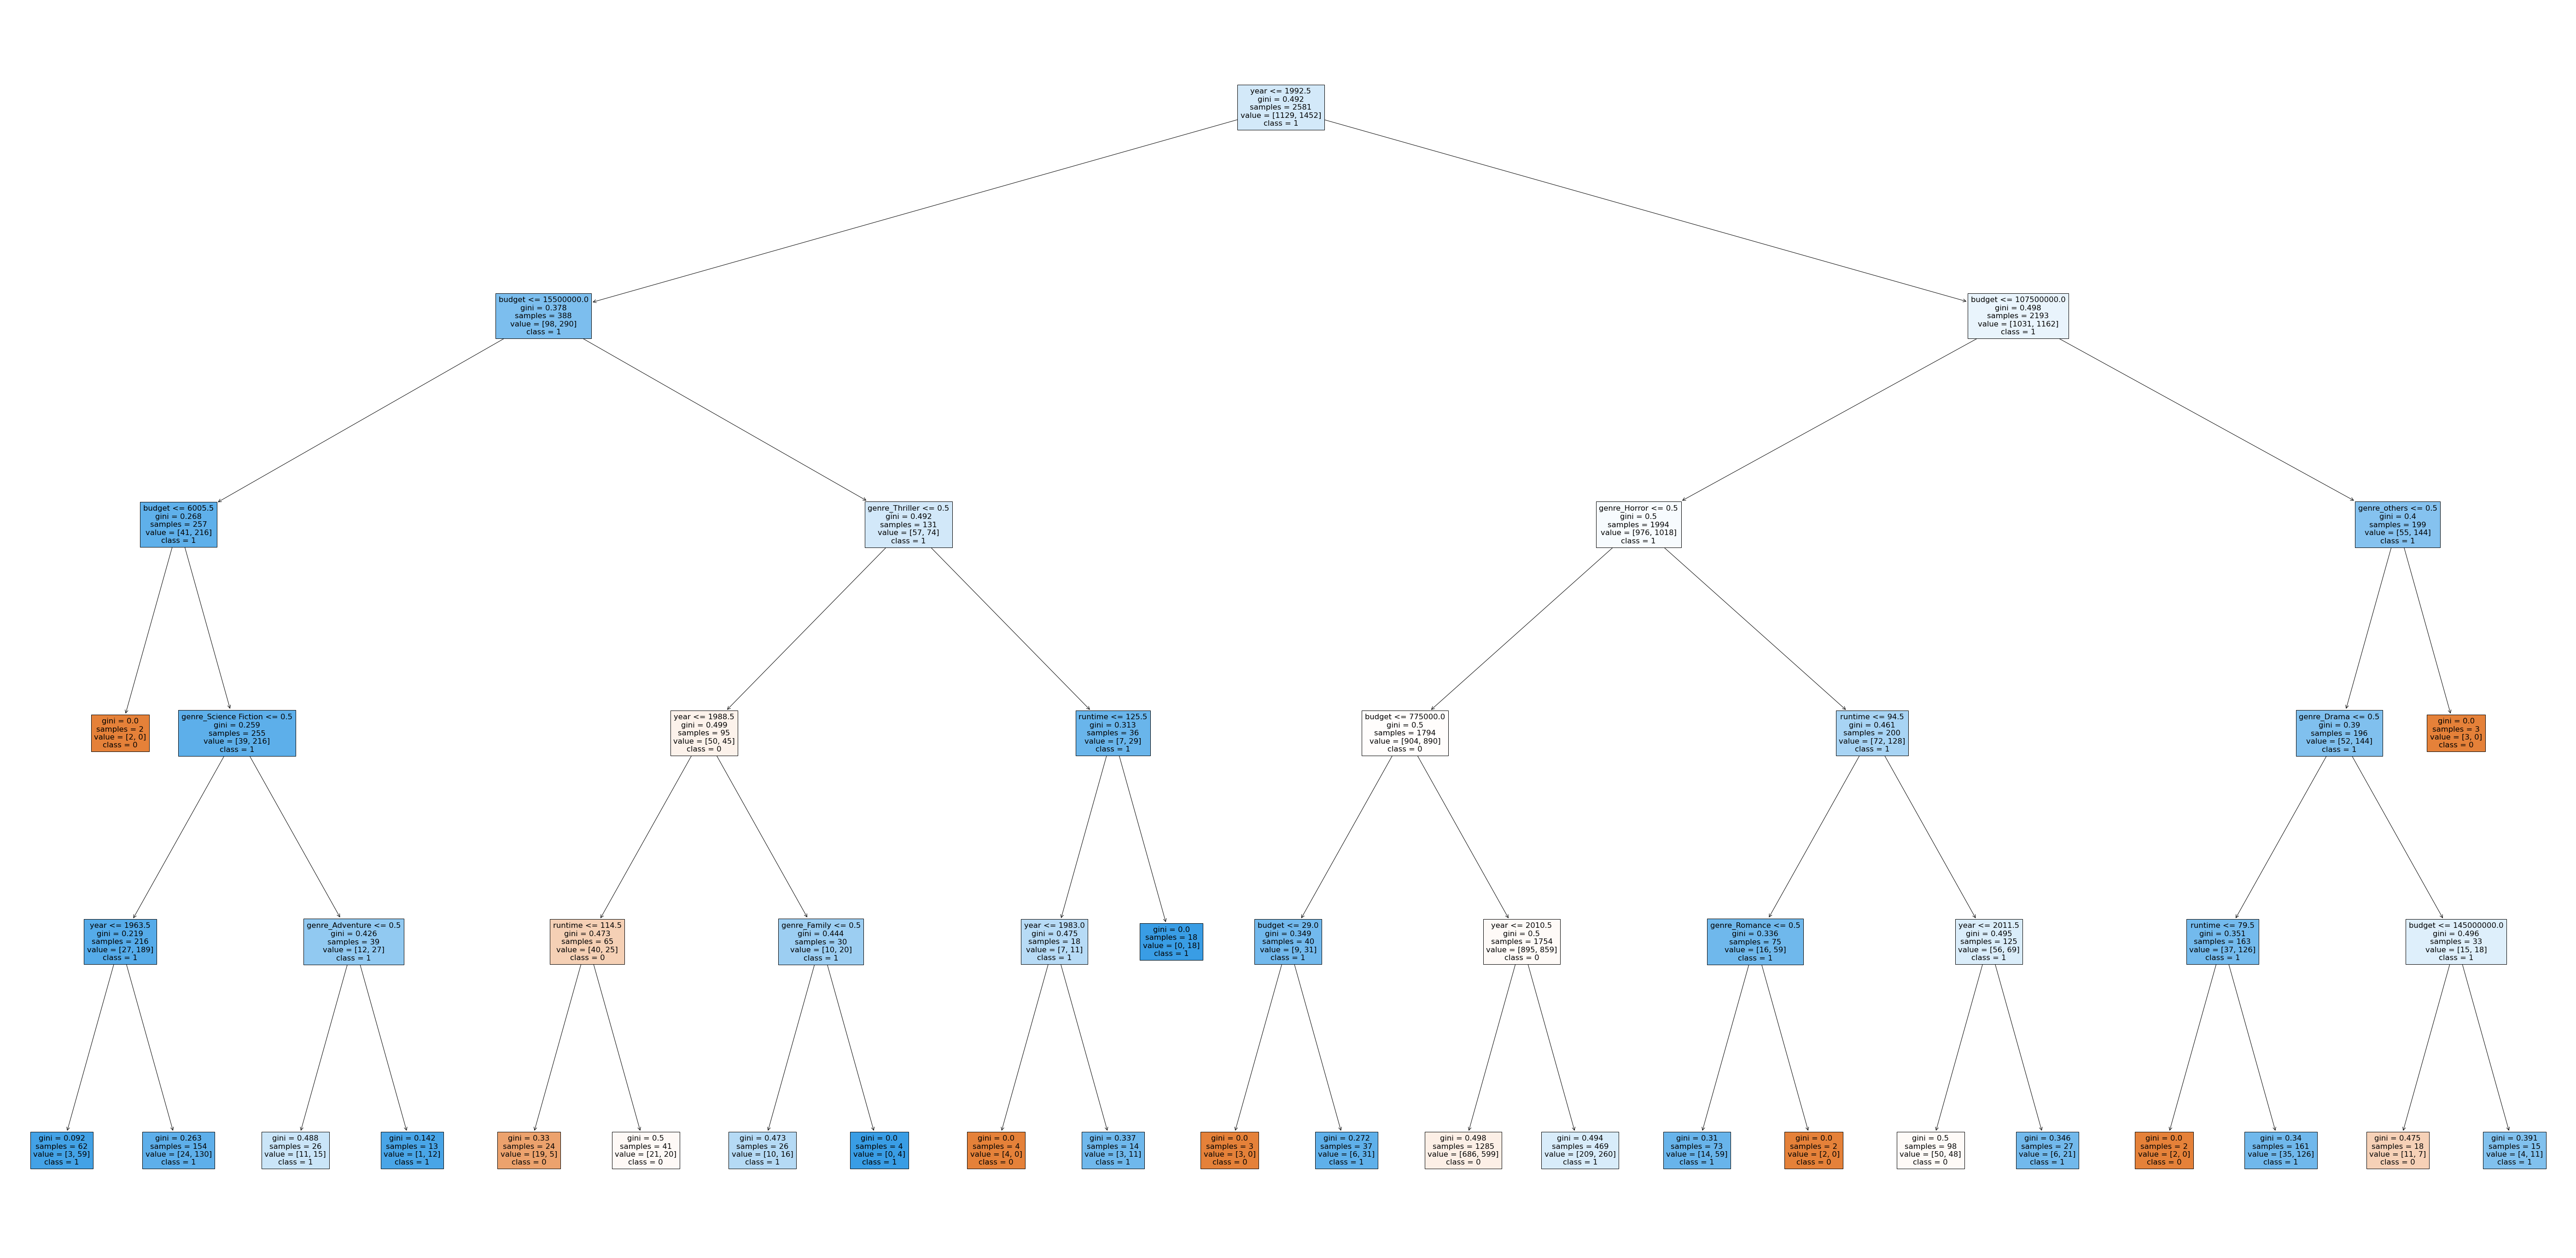

In [ ]:
#Showing the tree plot of Decision Tree for insighting
#https://mljar.com/blog/visualize-decision-tree/

fig = plt.figure(figsize=(100,50))
_ = tree.plot_tree(model_dt, feature_names = X_train.columns, class_names= ['0','1'], filled=True)

A plot of the decision tree is visualized so insights can be derived from the model built (e.g., checking of rules and conditions from the tree).

In [ ]:
#Keeping the decision tree plot as .png file for easier referencing

fig.savefig("/content/drive/MyDrive/CSCI 271 - Group 6/decision_tree.png")

### III. Insights from Decision Tree Model

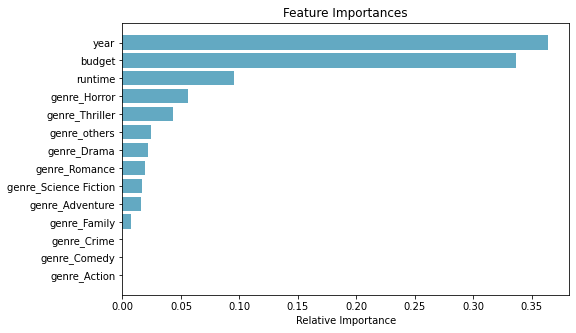

In [ ]:
features = X_train.columns
importances = model_dt.feature_importances_
indices = np.argsort(importances)

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black"}

plt.figure(figsize=(8,5))
plt.rcParams.update(params)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#63a9c2', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Based on the decision tree, most import features are year and budget. Other insights will be derived from analyzing the rules of the decision tree built

In [ ]:
#For the Insights from the nodes

In [ ]:
y_pred_train = model_dt.predict(X_train)
train_data = X_train.copy()
train_data["success_pred"] = y_pred_train

In [ ]:
#1: Invest Big in Dramas

In [ ]:
drama = train_data[train_data["year"] > 1992.5]
drama = drama[drama["budget"] > 107500000]
drama = drama[drama["genre_others"] == 0]
drama = drama[drama["genre_Drama"] == 1] 

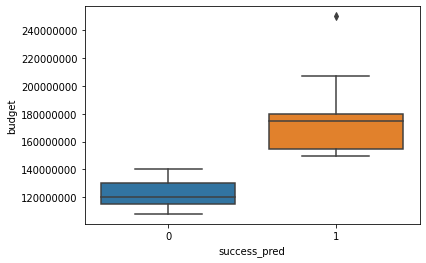

In [ ]:
sns.boxplot(y = drama['budget'], x = drama['success_pred'].astype('str'))
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [ ]:
#2: Non-drama films - keep it at least 79 minutes long

In [ ]:
nondrama = train_data[train_data["year"] > 1992.5]
nondrama = nondrama[nondrama["budget"] > 107500000]
nondrama = nondrama[nondrama["genre_others"] == 0]
nondrama = nondrama[nondrama["genre_Drama"] == 0] 

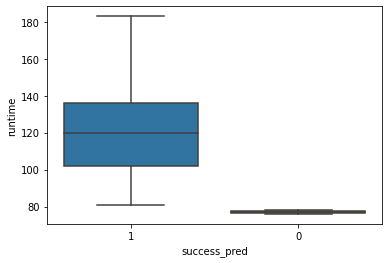

In [ ]:
sns.boxplot(y = nondrama['runtime'], x = nondrama['success_pred'].astype('str'))
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [ ]:
#3: Horror films still work with less budget needed to be successful; no need to go beyond 107,500,000

In [ ]:
horror = train_data[train_data["year"] > 1992.5]
horror = horror[horror["budget"] <= 107500000]
horror = horror[horror["genre_Horror"] == 0]

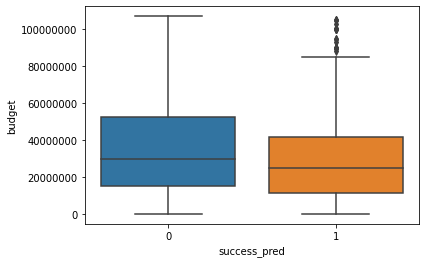

In [ ]:
sns.boxplot(y = horror['budget'], x = horror['success_pred'].astype('str'))
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [ ]:
#4: Keep Non-Romance horrors short At most 95 minutes

In [ ]:
nr_horror = train_data[train_data["year"] > 1992.5]
nr_horror = nr_horror[nr_horror["genre_Horror"] == 1]
nr_horror = nr_horror[nr_horror["runtime"] <= 94.5]

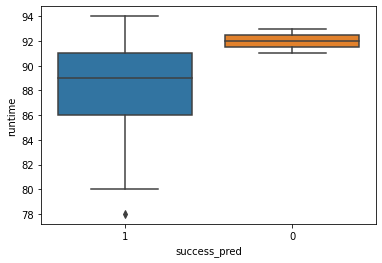

In [ ]:
sns.boxplot(y = nr_horror['runtime'], x = nr_horror['success_pred'].astype('str'))
plt.ticklabel_format(style='plain', axis='y')
plt.show()

The rules derived from the decision tree allow for insights behind the data in regards to movie success. The graphs shown above validate the decision tree rules and insights.

## IV. Appendix

### Other Charts Used in Report or Paper

Chart used for showing distribution of Movie ROI in report

Text(0.5, 1.0, 'Percent of Budget Earned as Gross Revenue (in decimal)')

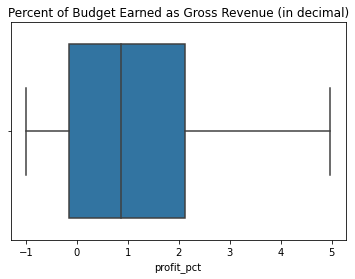

In [ ]:
outlier_cutoff = 5 #Set outlier cutoff for visualization purposes only

sns.boxplot(x = df_movies.loc[df_movies['profit_pct'] < 5,'profit_pct'])
plt.title('Percent of Budget Earned as Gross Revenue (in decimal)')

Charts showing summary statistics of movie budget and runtime

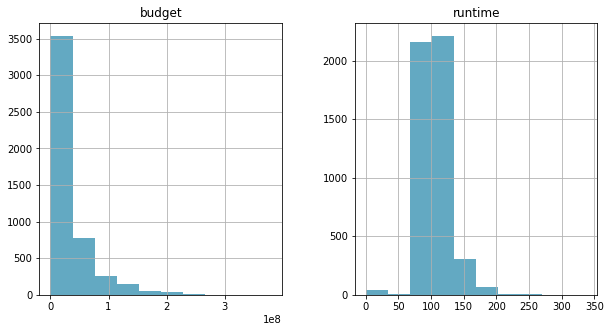

In [ ]:
df_movies[['budget','runtime']].hist(figsize=(10, 5), color='#63a9c2')
plt.ticklabel_format(style='plain', axis='y')
plt.show()